# Building Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it.

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-03-01
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1614656


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2329229
2329229
2210399
2210399


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))


* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1380484
30482
1095461
1125943


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). <strong>Be aware of this</strong>. <strike>This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute.</strike>

* <font color="red"><strong>Checking</strong></font>

In [9]:
threshold = 40 #In seconds

time_keys = []

cumulative_counts_turnstile = []
cumulative_counts_noturnstile = []

total_count_turnstile = filtered_turnstile_df.count()[0]
total_count_noturnstile = filtered_no_turnstile_df.count()[0]

for i in range(0,threshold):
    time_keys.append(i)
    cumulative_counts_turnstile.append(filtered_turnstile_df[filtered_turnstile_df['diferencia_tiempo_secs']<i].count()[0])
    cumulative_counts_noturnstile.append(filtered_no_turnstile_df[filtered_no_turnstile_df['diferencia_tiempo_secs']<i].count()[0])


cumulative_counts_turnstile = cumulative_counts_turnstile/total_count_turnstile
cumulative_counts_noturnstile = cumulative_counts_noturnstile/total_count_noturnstile

In [10]:
count_turnstile = filtered_turnstile_df[filtered_turnstile_df['diferencia_tiempo_secs']<=threshold].count()[0]
count_noturnstile = filtered_no_turnstile_df[filtered_no_turnstile_df['diferencia_tiempo_secs']<=threshold].count()[0]


percent_turnstile = (count_turnstile/total_count_turnstile)*100
percent_noturnstile = (count_noturnstile/total_count_noturnstile)*100

print(percent_turnstile)
print(percent_noturnstile)

96.791549111
97.0448970799


In [11]:
colors = [(244, 67, 54),(3, 169, 244),(205, 220, 57)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

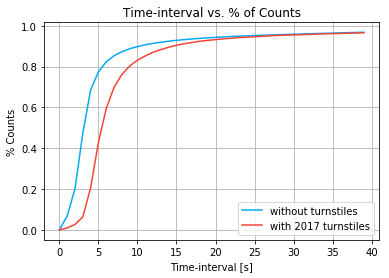

In [13]:
fig_1, ax_1 = plt.subplots()
plot1 = ax_1.plot(time_keys,cumulative_counts_noturnstile,color=colors[1],label='without turnstiles')
plot2 = ax_1.plot(time_keys,cumulative_counts_turnstile,color=colors[0],label='with 2017 turnstiles')
ax_1.set_title('Time-interval vs. % of Counts')
ax_1.set_xlabel('Time-interval [s]')
ax_1.set_ylabel('% Counts')
ax_1.legend()
ax_1.grid(True)
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/0_timeIntervalVsCounts_2017-03-01.pdf')

### Filtering by diferencia_tiempo<=95th percentile in the corresponding databases. <font color="red">BE AWARE.</font>

In [42]:
turnstile_95 = filtered_turnstile_df.diferencia_tiempo.quantile(0.95)
print ('Percentile 95th for 2017-turnstile database is: ' + str(turnstile_95))
no_turnstile_95 = filtered_no_turnstile_df.diferencia_tiempo.quantile(0.95)
print('Percentile 95th for without_turnstile database is: ' + str(no_turnstile_95))

Percentile 95th for 2017-turnstile database is: 0 days 00:00:26
Percentile 95th for without_turnstile database is: 0 days 00:00:23


In [43]:
turnstile_95_df = filtered_turnstile_df[filtered_turnstile_df.diferencia_tiempo<=turnstile_95]

In [44]:
no_turnstile_95_df = filtered_no_turnstile_df[filtered_no_turnstile_df.diferencia_tiempo<=no_turnstile_95]

In [45]:
turnstile_95_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.898600e+04,2.898600e+04,28986.000000,28986,28986.000000
mean,1.176673e+06,2.265119e+09,1.560512,0 days 00:00:05.908576,5.908577
std,6.778292e+05,1.303444e+09,0.823419,0 days 00:00:03.973483,3.973483
min,1.130000e+02,8.434730e+06,1.000000,0 days 00:00:00,0.000000
25%,5.899380e+05,9.820610e+08,1.000000,0 days 00:00:04,4.000000
50%,1.189868e+06,2.524481e+09,1.000000,0 days 00:00:05,5.000000
75%,1.766166e+06,3.460785e+09,2.000000,0 days 00:00:07,7.000000
max,2.329088e+06,4.287640e+09,14.000000,0 days 00:00:26,26.000000


In [46]:
no_turnstile_95_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.041554e+06,1.041554e+06,1.041554e+06,1041554,1.041554e+06
mean,1.169455e+06,2.252312e+09,1.638852e+00,0 days 00:00:03.364931,3.364932e+00
std,6.718603e+05,1.294400e+09,8.622337e-01,0 days 00:00:03.331787,3.331788e+00
min,0.000000e+00,5.454520e+05,1.000000e+00,0 days 00:00:00,0.000000e+00
25%,5.846775e+05,9.356997e+08,1.000000e+00,0 days 00:00:02,2.000000e+00
50%,1.170606e+06,2.512589e+09,1.000000e+00,0 days 00:00:03,3.000000e+00
75%,1.752290e+06,3.418041e+09,2.000000e+00,0 days 00:00:04,4.000000e+00
max,2.329226e+06,4.293302e+09,1.900000e+01,0 days 00:00:23,2.300000e+01


* Plotting

In [40]:
turns_vals = turnstile_95_df.diferencia_tiempo_secs.values
no_turns_vals = no_turnstile_95_df.diferencia_tiempo_secs.values
max_95 = max(turnstile_95,no_turnstile_95).total_seconds()
bins = range(0,int(max_95),1)

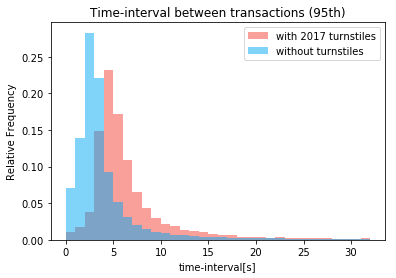

In [41]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(turns_vals,normed=True,bins=bins,color=colors[0], alpha=0.5, label='with 2017 turnstiles')
plot2 = ax.hist(no_turns_vals,normed=True,bins=bins,color=colors[1], alpha = 0.5, label='without turnstiles')


ax.set_title('Time-interval between transactions (95th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/2017-07-19.pdf')